### **Import Necessary Libraries**

In [1]:
!pip install transformers -q

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import cv2

### **Dataset Manipulation**

In [3]:
# Set the path to the dataset
dataset_path = '/kaggle/input/cassava-leaf-disease-classification/data'

# List all the subdirectories (class folders) in the dataset
class_folders = os.listdir(dataset_path)

# Initialize an empty DataFrame to store the data
df = pd.DataFrame(columns=['image_path', 'label'])

# Loop through each class folder
for class_folder in class_folders:
    class_path = os.path.join(dataset_path, class_folder)

    # List all the images in the class folder, limited to the first 1000
    images = os.listdir(class_path)[:1000]

    # Add each full image path and its corresponding label to the DataFrame
    data = [{'image_path': os.path.join(class_path, image), 'label': class_folder.split('___')[1]} for image in images]
    df = pd.concat([df, pd.DataFrame(data)])

# Display the first few rows of the DataFrame
df.head()


,image_path,label
0,/kaggle/input/cassava-leaf-disease-classificat...,mosaic_disease
1,/kaggle/input/cassava-leaf-disease-classificat...,mosaic_disease
2,/kaggle/input/cassava-leaf-disease-classificat...,mosaic_disease
3,/kaggle/input/cassava-leaf-disease-classificat...,mosaic_disease
4,/kaggle/input/cassava-leaf-disease-classificat...,mosaic_disease


In [4]:
# Count the occurrences of each label
label_counts = df['label'].value_counts()

# Display the number of labels and their counts
print("Number of unique labels:", len(label_counts))
print("\nLabel counts:")
print(label_counts)


Number of unique labels: 5

Label counts:
label
mosaic_disease          1000
brown_streak_disease    1000
bacterial_blight        1000
green_mottle            1000
healthy                 1000
Name: count, dtype: int64


### **This code first splits the dataset into 80% training (train_df) and 20% combined testing and validation (test_val_df). Then, it further splits the testing and validation set equally, resulting in a final 80% training set, 10% testing set, and 10% validation set.**

In [5]:
from sklearn.model_selection import train_test_split

# Split the dataset into train, test, and validation sets
train_df, test_val_df = train_test_split(df, test_size=0.2, random_state=42)
test_df, val_df = train_test_split(test_val_df, test_size=0.5, random_state=42)

# Display the number of samples in each set
print("Train set size:", len(train_df))
print("Test set size:", len(test_df))
print("Validation set size:", len(val_df))


Train set size: 4000
Test set size: 500
Validation set size: 500


### **Image Display Function for Visualizing Unique Class Samples in a Dataset**

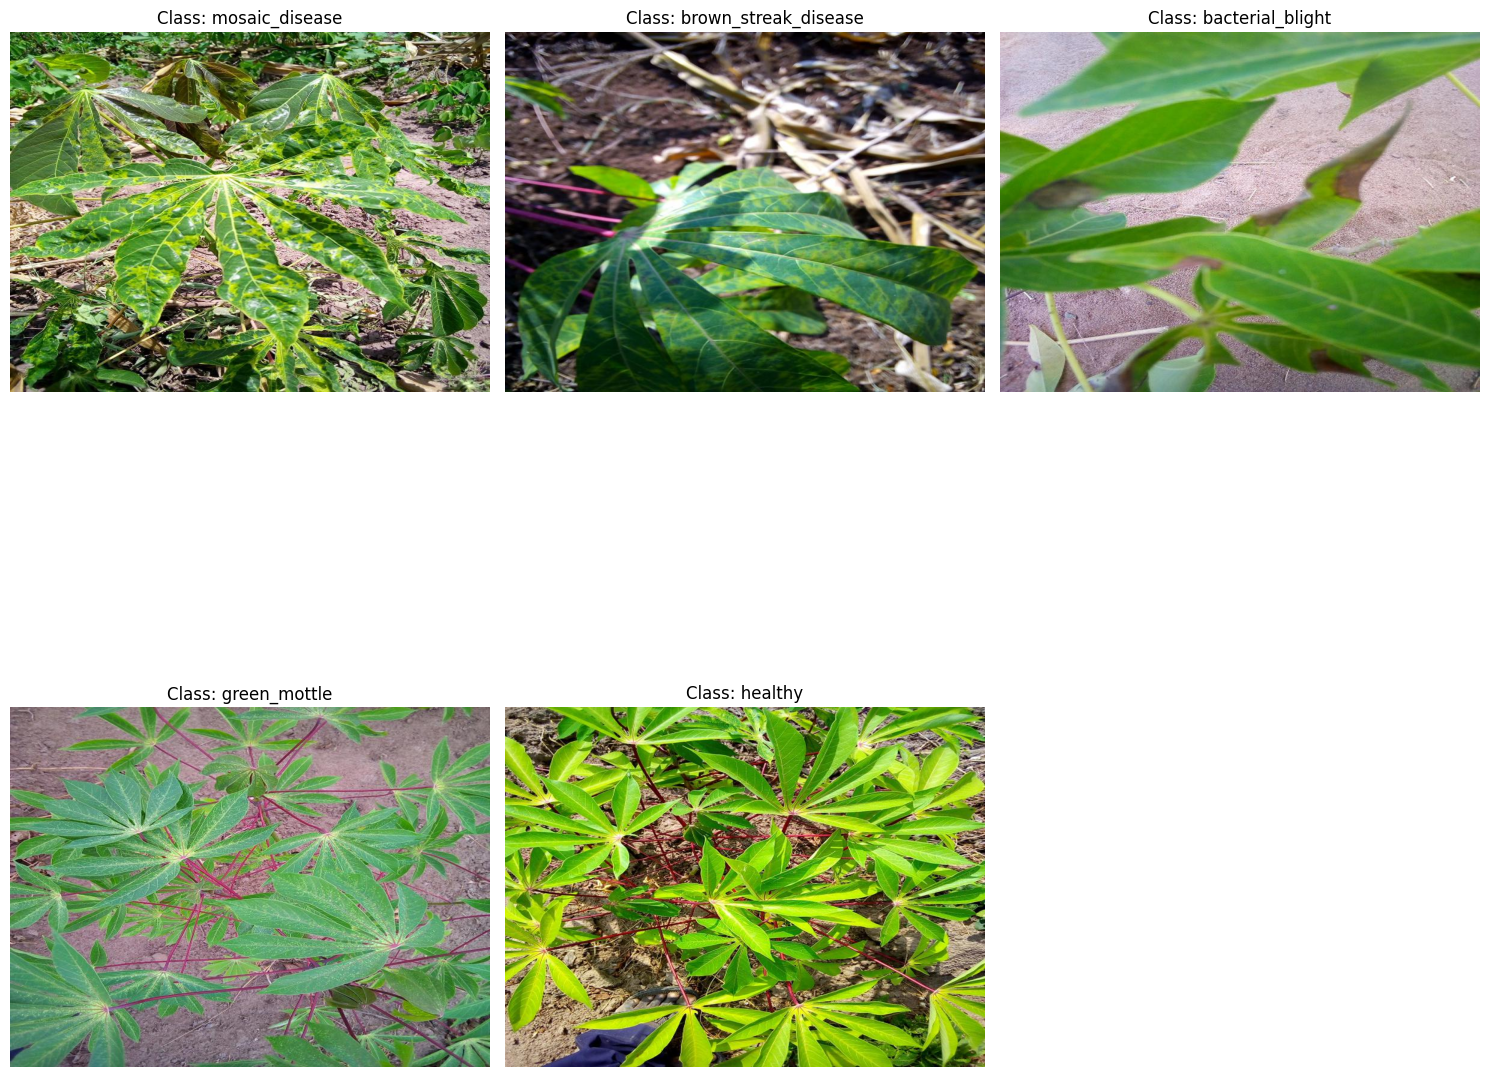

In [6]:
# Function to display images using subplots
def display_images_subplot(images, labels, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15), tight_layout=True)  # Add tight_layout=True
    axes = axes.flatten()

    for i in range(len(images)):
        full_path = os.path.join(dataset_path, images[i])
        image = cv2.imread(full_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV reads images in BGR format, convert to RGB
        axes[i].imshow(image)
        axes[i].set_title(f'Class: {labels[i]}')
        axes[i].axis('off')

    # Remove empty subplots
    for j in range(len(images), len(axes)):
        fig.delaxes(axes[j])

    plt.show()

# Select one image per class for display
unique_labels = df['label'].unique()
selected_images = []
selected_labels = []

for class_label in unique_labels:
    class_image = df[df['label'] == class_label].iloc[0]  # Select the first image for each class
    selected_images.append(class_image['image_path'])
    selected_labels.append(class_label)

# Calculate the number of rows and columns based on the number of unique labels
rows = 2  
cols = 3 

# Display images using subplots
display_images_subplot(selected_images, selected_labels, rows, cols)


### **Image size in train dataset**

In [7]:
from PIL import Image

# Load the first image in the train_df DataFrame
image_path = train_df['image_path'].iloc[0]
image = Image.open(image_path)

# Get the dimensions (size) of the image
image_size = image.size
print("Image size:", image_size)

Image size: (800, 600)


### **Image size in test dataset**

In [8]:
from PIL import Image

# Load the first image in the test_df DataFrame
image_path = test_df['image_path'].iloc[0]
image = Image.open(image_path)

# Get the dimensions (size) of the image
image_size = image.size
print("Image size:", image_size)

Image size: (800, 600)


### **Image size in validation dataset**

In [9]:
from PIL import Image

# Load the first image in the test_df DataFrame
image_path = val_df['image_path'].iloc[0]
image = Image.open(image_path)

# Get the dimensions (size) of the image
image_size = image.size
print("Image size:", image_size)

Image size: (800, 600)


### **Loading Pre-trained Swiftformer Image Processor and Model**

In [13]:
from transformers import AutoImageProcessor, AutoModelForImageClassification
import torch

# Load pre-trained Swin Transformer image processor and model
feature_extractor = AutoImageProcessor.from_pretrained("MBZUAI/swiftformer-xs")

### **Dataset Preprocessing and DataLoader Setup for Cassava Leaf Disease Classification**

In [14]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder

# Define the image transformation
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Create a label encoder and fit it on your labels
label_encoder = LabelEncoder()
label_encoder.fit(train_df['label'])

# Convert labels to numerical representation
train_df['encoded_label'] = label_encoder.transform(train_df['label'])
val_df['encoded_label'] = label_encoder.transform(val_df['label'])
test_df['encoded_label'] = label_encoder.transform(test_df['label'])

class CassavaDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths.iloc[idx]  # Access image path using iloc
        label = self.labels.iloc[idx]  # Access label using iloc

        # Load and preprocess image
        image = Image.open(img_path).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)  # Apply the composed transformation

        return image, label



### **Processing Dataset Samples with Swiftformer Feature Extractor**

In [16]:
def process_example(example):
    # Assuming the dataset returns a tuple with image_path and labels
    image_path, labels = example[0], example[1]

    # Use your feature_extractor to process the image_path
    inputs = feature_extractor(image_path, return_tensors='pt')
    inputs['labels'] = labels

    return inputs

In [19]:
    # Training dataset and loader
train_dataset_encoded = CassavaDataset(train_df['image_path'], train_df['encoded_label'], transform=transform)
train_loader = DataLoader(train_dataset_encoded, batch_size=10, shuffle=True, collate_fn=process_example)

# Validation dataset and loader
val_dataset_encoded = CassavaDataset(val_df['image_path'], val_df['encoded_label'], transform=transform)
val_loader = DataLoader(val_dataset_encoded, batch_size=10, shuffle=True, collate_fn=process_example)

# Test dataset and loader
test_dataset_encoded = CassavaDataset(test_df['image_path'], test_df['encoded_label'], transform=transform)
test_loader = DataLoader(test_dataset_encoded, batch_size=10, shuffle=False, collate_fn=process_example)


In [20]:
# Get one sample from each dataset
sample_train = train_dataset_encoded[0]
sample_val = val_dataset_encoded[0]
sample_test = test_dataset_encoded[0]

# Process each sample using the process_example function
processed_train = process_example(sample_train)
processed_val = process_example(sample_val)
processed_test = process_example(sample_test)

In [21]:
# Display the processed samples
print("Processed Train Sample:")
print(processed_train)

Processed Train Sample:
{'pixel_values': tensor([[[[-2.1152, -2.1151, -2.1147,  ..., -2.1141, -2.1145, -2.1145],
          [-2.1148, -2.1149, -2.1148,  ..., -2.1145, -2.1144, -2.1142],
          [-2.1143, -2.1146, -2.1147,  ..., -2.1145, -2.1143, -2.1141],
          ...,
          [-2.1178, -2.1177, -2.1176,  ..., -2.1098, -2.1093, -2.1092],
          [-2.1178, -2.1177, -2.1176,  ..., -2.1086, -2.1083, -2.1088],
          [-2.1178, -2.1177, -2.1176,  ..., -2.1092, -2.1095, -2.1102]],

         [[-2.0328, -2.0328, -2.0328,  ..., -2.0326, -2.0328, -2.0328],
          [-2.0328, -2.0329, -2.0328,  ..., -2.0330, -2.0328, -2.0326],
          [-2.0328, -2.0328, -2.0326,  ..., -2.0329, -2.0326, -2.0324],
          ...,
          [-2.0356, -2.0356, -2.0355,  ..., -2.0294, -2.0288, -2.0286],
          [-2.0356, -2.0356, -2.0355,  ..., -2.0282, -2.0280, -2.0284],
          [-2.0356, -2.0356, -2.0355,  ..., -2.0288, -2.0293, -2.0300]],

         [[-1.8031, -1.8031, -1.8031,  ..., -1.8029, -1.8035,

In [22]:
print("\nProcessed Validation Sample:")
print(processed_val)


Processed Validation Sample:
{'pixel_values': tensor([[[[-2.1154, -2.1159, -2.1161,  ..., -2.1124, -2.1137, -2.1155],
          [-2.1160, -2.1157, -2.1156,  ..., -2.1132, -2.1155, -2.1170],
          [-2.1162, -2.1156, -2.1153,  ..., -2.1149, -2.1162, -2.1167],
          ...,
          [-2.1088, -2.1084, -2.1082,  ..., -2.1175, -2.1176, -2.1176],
          [-2.1092, -2.1087, -2.1084,  ..., -2.1174, -2.1176, -2.1177],
          [-2.1091, -2.1088, -2.1087,  ..., -2.1168, -2.1171, -2.1174]],

         [[-2.0305, -2.0309, -2.0309,  ..., -2.0297, -2.0306, -2.0321],
          [-2.0308, -2.0305, -2.0304,  ..., -2.0310, -2.0330, -2.0341],
          [-2.0308, -2.0304, -2.0300,  ..., -2.0332, -2.0342, -2.0342],
          ...,
          [-2.0238, -2.0234, -2.0232,  ..., -2.0308, -2.0309, -2.0309],
          [-2.0242, -2.0236, -2.0233,  ..., -2.0307, -2.0308, -2.0309],
          [-2.0241, -2.0238, -2.0237,  ..., -2.0302, -2.0304, -2.0306]],

         [[-1.8021, -1.8024, -1.8023,  ..., -1.8031, -1

In [23]:
print("\nProcessed Test Sample:")
print(processed_test)


Processed Test Sample:
{'pixel_values': tensor([[[[-2.1012, -2.1010, -2.1016,  ..., -2.1010, -2.1008, -2.1008],
          [-2.1026, -2.1023, -2.1021,  ..., -2.1014, -2.1010, -2.1008],
          [-2.1028, -2.1035, -2.1037,  ..., -2.1042, -2.1026, -2.1017],
          ...,
          [-2.1125, -2.1125, -2.1127,  ..., -2.1136, -2.1132, -2.1133],
          [-2.1153, -2.1155, -2.1158,  ..., -2.1144, -2.1133, -2.1128],
          [-2.1173, -2.1171, -2.1169,  ..., -2.1161, -2.1149, -2.1137]],

         [[-2.0184, -2.0183, -2.0190,  ..., -2.0183, -2.0182, -2.0182],
          [-2.0200, -2.0196, -2.0194,  ..., -2.0188, -2.0183, -2.0182],
          [-2.0203, -2.0209, -2.0210,  ..., -2.0218, -2.0201, -2.0191],
          ...,
          [-2.0305, -2.0306, -2.0310,  ..., -2.0312, -2.0314, -2.0317],
          [-2.0333, -2.0339, -2.0342,  ..., -2.0323, -2.0320, -2.0317],
          [-2.0354, -2.0355, -2.0354,  ..., -2.0343, -2.0340, -2.0330]],

         [[-1.7877, -1.7874, -1.7876,  ..., -1.7872, -1.7871,

### **Printing Sizes of the First 10 Images from the Train Dataset with Labels**

In [24]:
# Print sizes of the first 10 images from the train dataset with labels
print("Train dataset - Image sizes:")
for i in range(10):
    img_path = train_df['image_path'].iloc[i]
    label = train_df['label'].iloc[i]
 
    # Load and preprocess image
    image = Image.open(img_path).convert('RGB')
    if transform is not None:
        image = transform(image)  # Apply the composed transformation

    print(f"Sample {i + 1} - Label: {label}, Image Size: {image.size()}")


Train dataset - Image sizes:
Sample 1 - Label: healthy, Image Size: torch.Size([3, 256, 256])
Sample 2 - Label: healthy, Image Size: torch.Size([3, 256, 256])
Sample 3 - Label: mosaic_disease, Image Size: torch.Size([3, 256, 256])
Sample 4 - Label: green_mottle, Image Size: torch.Size([3, 256, 256])
Sample 5 - Label: healthy, Image Size: torch.Size([3, 256, 256])
Sample 6 - Label: bacterial_blight, Image Size: torch.Size([3, 256, 256])
Sample 7 - Label: healthy, Image Size: torch.Size([3, 256, 256])
Sample 8 - Label: healthy, Image Size: torch.Size([3, 256, 256])
Sample 9 - Label: bacterial_blight, Image Size: torch.Size([3, 256, 256])
Sample 10 - Label: bacterial_blight, Image Size: torch.Size([3, 256, 256])


### **Printing Sizes of the First 10 Images from the Test Dataset with Labels**

In [25]:
# Print sizes of the first 10 images from the test dataset with labels
print("Test dataset - Image sizes:")
for i in range(10):
    img_path = test_df['image_path'].iloc[i]
    label = test_df['label'].iloc[i]

    # Load and preprocess image
    image = Image.open(img_path).convert('RGB')
    if transform is not None:
        image = transform(image)  # Apply the composed transformation

    print(f"Sample {i + 1} - Label: {label}, Image Size: {image.size()}")


Test dataset - Image sizes:
Sample 1 - Label: bacterial_blight, Image Size: torch.Size([3, 256, 256])
Sample 2 - Label: green_mottle, Image Size: torch.Size([3, 256, 256])
Sample 3 - Label: bacterial_blight, Image Size: torch.Size([3, 256, 256])
Sample 4 - Label: brown_streak_disease, Image Size: torch.Size([3, 256, 256])
Sample 5 - Label: mosaic_disease, Image Size: torch.Size([3, 256, 256])
Sample 6 - Label: brown_streak_disease, Image Size: torch.Size([3, 256, 256])
Sample 7 - Label: healthy, Image Size: torch.Size([3, 256, 256])
Sample 8 - Label: bacterial_blight, Image Size: torch.Size([3, 256, 256])
Sample 9 - Label: brown_streak_disease, Image Size: torch.Size([3, 256, 256])
Sample 10 - Label: green_mottle, Image Size: torch.Size([3, 256, 256])


### **Printing Sizes of the First 10 Images from the Validation Dataset with Labels**

In [26]:
# Print sizes of the first 10 images from the val dataset with labels
print("Validation dataset - Image sizes:")
for i in range(10):
    img_path = val_df['image_path'].iloc[i]
    label = val_df['label'].iloc[i]

    # Load and preprocess image
    image = Image.open(img_path).convert('RGB')
    if transform is not None:
        image = transform(image)  # Apply the composed transformation

    print(f"Sample {i + 1} - Label: {label}, Image Size: {image.size()}")


Validation dataset - Image sizes:
Sample 1 - Label: green_mottle, Image Size: torch.Size([3, 256, 256])
Sample 2 - Label: mosaic_disease, Image Size: torch.Size([3, 256, 256])
Sample 3 - Label: bacterial_blight, Image Size: torch.Size([3, 256, 256])
Sample 4 - Label: brown_streak_disease, Image Size: torch.Size([3, 256, 256])
Sample 5 - Label: green_mottle, Image Size: torch.Size([3, 256, 256])
Sample 6 - Label: healthy, Image Size: torch.Size([3, 256, 256])
Sample 7 - Label: brown_streak_disease, Image Size: torch.Size([3, 256, 256])
Sample 8 - Label: mosaic_disease, Image Size: torch.Size([3, 256, 256])
Sample 9 - Label: bacterial_blight, Image Size: torch.Size([3, 256, 256])
Sample 10 - Label: healthy, Image Size: torch.Size([3, 256, 256])


In [27]:
import numpy as np
from datasets import load_metric
import torch

### **Custom Collate Function for PyTorch Dataloader in Image Classification**

In [28]:
def collate_fn(batch):
    images, labels = zip(*batch)

    return {
        'pixel_values': torch.stack(images),
        'labels': torch.tensor(labels)
    }

### **Metrics Computation Function for Image Classification Model Evaluation**

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(p):
    predictions = np.argmax(p.predictions, axis=1)
    references = p.label_ids

    accuracy = accuracy_score(references, predictions)
    precision = precision_score(references, predictions, average='weighted')
    recall = recall_score(references, predictions, average='weighted')
    f1 = f1_score(references, predictions, average='weighted')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }


In [31]:
model_name_or_path = "MBZUAI/swiftformer-xs"

### **Initializing Swin Transformer Model for Image Classification with Custom Labels Mapping**

In [32]:
# Initialize the Swin Transformer model for image classification
model = AutoModelForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(label_encoder.classes_),
    ignore_mismatched_sizes=True,
    id2label={str(i): c for i, c in enumerate(label_encoder.classes_)},
    label2id={c: str(i) for i, c in enumerate(label_encoder.classes_)}
)

model.safetensors:   0%|          | 0.00/14.0M [00:00<?, ?B/s]

Some weights of SwiftFormerForImageClassification were not initialized from the model checkpoint at MBZUAI/swiftformer-xs and are newly initialized because the shapes did not match:
- dist_head.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- dist_head.weight: found shape torch.Size([1000, 220]) in the checkpoint and torch.Size([5, 220]) in the model instantiated
- head.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- head.weight: found shape torch.Size([1000, 220]) in the checkpoint and torch.Size([5, 220]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
model

SwiftFormerForImageClassification(
  (swiftformer): SwiftFormerModel(
    (patch_embed): SwiftFormerPatchEmbedding(
      (patch_embedding): Sequential(
        (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (4): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
    )
    (encoder): SwiftFormerEncoder(
      (network): ModuleList(
        (0): SwiftFormerStage(
          (blocks): ModuleList(
            (0-1): 2 x SwiftFormerConvEncoder(
              (depth_wise_conv): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48)
              (norm): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (point_wise_conv1): Conv2d(48, 192, kernel_size=(1

### **Configuring Training Arguments for Swiftformer Model Training on Cassava Leaf Disease Dataset**

In [34]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./swiftformer-base-Cassava-demo-v5",
  per_device_train_batch_size=10,
  evaluation_strategy="steps",
  num_train_epochs=5,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

### **Initializing Trainer for Swiftformer Model Training on Cassava Leaf Disease Dataset**

In [35]:
from transformers import Trainer
# Create a Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=train_loader.dataset,
    eval_dataset=val_loader.dataset,
    tokenizer=feature_extractor,
)


### **Training Swiftformer Model on Cassava Leaf Disease Dataset**

In [36]:
train_results = trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
100,1.266900,1.094410,0.558000,0.557344,0.558000,0.548298
200,1.085900,1.019640,0.594000,0.652223,0.594000,0.588770
300,1.068900,0.859508,0.668000,0.675898,0.668000,0.664609
400,1.036000,0.829814,0.684000,0.691190,0.684000,0.679277
500,0.735100,0.761500,0.708000,0.719936,0.708000,0.709168
600,0.653500,0.777665,0.714000,0.720206,0.714000,0.714561
700,0.824700,0.719075,0.754000,0.761293,0.754000,0.754625
800,0.963800,0.731036,0.714000,0.744560,0.714000,0.710834
900,0.464400,0.766413,0.710000,0.712487,0.710000,0.704678
1000,0.413400,0.738633,0.732000,0.741739,0.732000,0.732814


### **Saving Swiftformer Model and Training Metrics After Training on Cassava Leaf Disease Dataset**

In [37]:
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =        5.0
  total_flos               = 66699536GF
  train_loss               =     0.5894
  train_runtime            = 0:07:18.60
  train_samples_per_second =     45.599
  train_steps_per_second   =       4.56


### **Evaluating Swiftformer Model on Validation Set and Logging Metrics**

In [38]:
metrics = trainer.evaluate(val_loader.dataset)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        5.0
  eval_accuracy           =      0.754
  eval_f1                 =     0.7546
  eval_loss               =     0.7191
  eval_precision          =     0.7613
  eval_recall             =      0.754
  eval_runtime            = 0:00:05.35
  eval_samples_per_second =     93.287
  eval_steps_per_second   =     11.754


### **Evaluating Swiftformer Model on Test Set and Logging Evaluation Metrics**

In [39]:
metrics = trainer.evaluate(test_loader.dataset)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        5.0
  eval_accuracy           =      0.728
  eval_f1                 =     0.7285
  eval_loss               =     0.6841
  eval_precision          =     0.7309
  eval_recall             =      0.728
  eval_runtime            = 0:00:07.75
  eval_samples_per_second =      64.44
  eval_steps_per_second   =      8.119


In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate on the test dataset
test_results = trainer.predict(test_loader.dataset)

# Compute metrics
metrics = compute_metrics(test_results)

# Print the computed metrics
print(f"Accuracy: {metrics['accuracy']:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall: {metrics['recall']:.4f}")
print(f"F1 Score: {metrics['f1']:.4f}")


Accuracy: 0.7280
Precision: 0.7309
Recall: 0.7280
F1 Score: 0.7285


### **Confusion Matrix for Cassava Leaf Disease Classification**

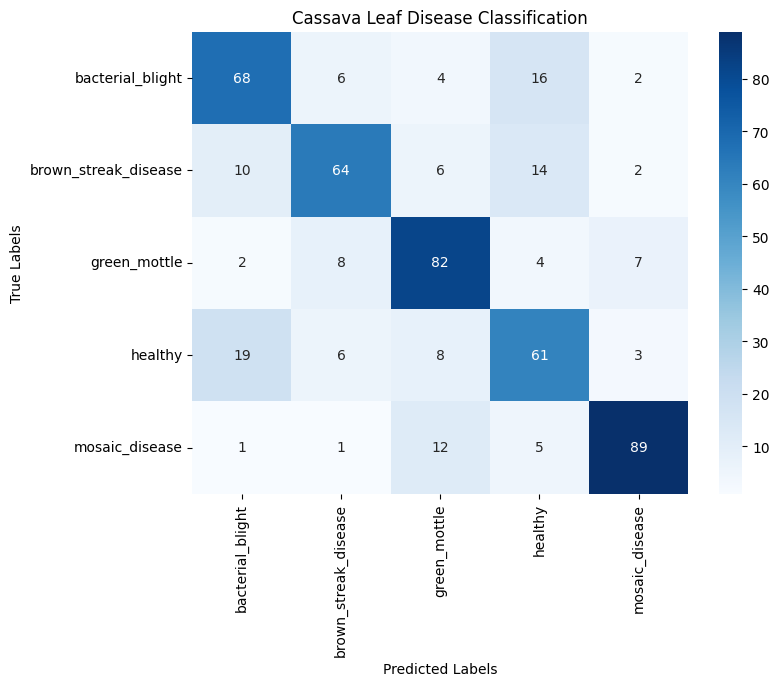

In [41]:
# Compute and display the confusion matrix
conf_matrix = confusion_matrix(test_results.label_ids, np.argmax(test_results.predictions, axis=1))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Cassava Leaf Disease Classification')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()